# Transformer Encoder for Tweet Hatespeech Classification

Implementation adapted from <a href="https://towardsdatascience.com/text-classification-with-transformer-encoders-1dcaa50dabae"> Ruben Winastwan's model</a> for classifying emails as spam or not spam.

The transformer architecture as described in "Attention is All You Need" (Vaswani et al.) are used for text generation or translation tasks, and use both an encoder and decoder. 

The encoder portion of the architecture can be used by itself for classification tasks. This implementation uses this idea to classify text as containing hatespeech/offensive language or not.

### Import Libraries, Load the dataset

In [106]:
import math
import torch
import torch.nn as nn
import torchtext
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
DATA_PATH = "data/labeled_data.csv"

tweets_df = pd.read_csv(DATA_PATH)
tweets_df=tweets_df[["class","tweet"]]

### CLASS 1 : Contains no hatespeech  language or hatespeech
### CLASS 0 : Contains offensive language / hatespeech
tweets_df["class"] = tweets_df["class"].replace({2: 1, 0: 0, 1: 1})

np.random.seed(42)

df_train, df_test = train_test_split(tweets_df,test_size=0.2)
print(df_train.head())

       class  \
15272      0   
9351       1   
20323      1   
3638       1   
20579      1   

                                                                                                                                                                                                                                                                                    tweet  
15272                                                                                                                                  RT @FunSizedYogi: @TheBlackVoice well how else will white ppl get us to forget our horrific past other than to paint a pretty picture of ho&#8230;  
9351                                                                                                                                                     Funny thing is....it's not just the people doing it. It's the people who seeing these pics and judging the birds. Just as wrong.  
20323  RT @winkSOSA: "@AintShitSweet__: "@Rakwon_OG

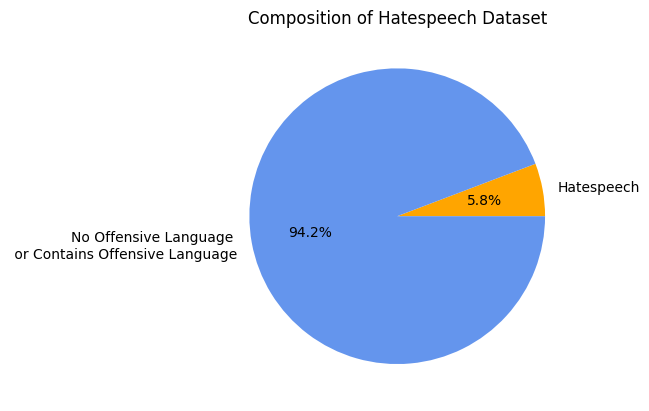

In [108]:
labels = 'Hatespeech', 'No Offensive Language \n or Contains Offensive Language'
sizes = [tweets_df['class'].value_counts()[0], tweets_df['class'].value_counts()[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
ax.set_title("Composition of Hatespeech Dataset")
plt.show()

## Investigating How Accurate Filtering By Insults is

Why do we need a machine learning model to look for hatespeech and offensive language?
Here I will try the common strategy of simply flagging words known to be offensive by using a dataset of offensive words found on this github repository : 

In [109]:
import requests
import csv

CSV_URL="https://raw.githubusercontent.com/surge-ai/profanity/main/profanity_en.csv"

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    print(my_list)
insults_df=pd.DataFrame(my_list)
insults_df.columns = insults_df.iloc[0]
insults_df=insults_df[["text","canonical_form_1","category_1","severity_description"]]

tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

severe_insults_df = insults_df[(insults_df["severity_description"] == "Severe")]

# insults_df.head(30)
# severe_insults_df.tail(30)



[['text', 'canonical_form_1', 'canonical_form_2', 'canonical_form_3', 'category_1', 'category_2', 'category_3', 'severity_rating', 'severity_description'], ['69', '69', '', '', 'sexual anatomy / sexual acts', '', '', '1', 'Mild'], ['@55', 'ass', '', '', 'sexual anatomy / sexual acts', '', '', '1', 'Mild'], ['@ssfcker', 'fuck', 'ass', '', 'sexual anatomy / sexual acts', 'sexual orientation / gender', '', '2.8', 'Severe'], ['@ssfucker', 'fuck', 'ass', '', 'sexual anatomy / sexual acts', 'sexual orientation / gender', '', '2.8', 'Severe'], ['@ssfvcker', 'fuck', 'ass', '', 'sexual anatomy / sexual acts', 'sexual orientation / gender', '', '2.4', 'Strong'], ['@sshole', 'ass', '', '', 'sexual anatomy / sexual acts', '', '', '1.6', 'Strong'], ['0ral seks', 'sex', '', '', 'sexual anatomy / sexual acts', '', '', '1', 'Mild'], ['0ral sex', 'sex', '', '', 'sexual anatomy / sexual acts', '', '', '1.8', 'Strong'], ['0rg@sm', 'orgasm', '', '', 'sexual anatomy / sexual acts', '', '', '1', 'Mild'], ['

In [110]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

def find_first_insult(tweet, df):
    words = tweet.split(" ")
    # print(tweet)
    insults = []
    for word in words:
        word = word.strip()
        # print(word)
        
        if df['text'].isin([word]).any():
            insults.append(word)
    if len(insults) > 0:
        return insults
    else:
        return None
    
def contains_insult(tweet, df):
    words = tweet.split(" ")
    # print(tweet)
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            return True
    return False


# find insults in each tweet
tweets_df['contains_insult'] = tweets_df['tweet'].apply(lambda x: find_first_insult(x,insults_df))
tweets_df['contains_severe_insult'] = tweets_df['tweet'].apply(lambda x: contains_insult(x,severe_insults_df))

# Filter tweets containing insults from the insult dataset
offensive_tweets = tweets_df[tweets_df['class'] == 0]
inoffensive_tweets = tweets_df[tweets_df['class'] == 1]




In [111]:

insult_offensive_categories = {}
insult_inoffensive_categories = {}

def category_of_insults(insult_list, df, offensive = True):
    global insult_offensive_categories
    global insult_inoffensive_categories
    categories = []
    if insult_list == None:
        return None
    for insult in insult_list:
        if not df['text'].isin([insult]).any():
            continue
        row = df[df['text'].str.contains(insult)].iloc[0]['category_1']
        category = row.strip()
        if category == 'category_1':
            continue
        categories.append(category)
        if offensive:
            if insult in insult_offensive_words:
                insult_offensive_words[insult] += 1
            else:
                insult_offensive_words[insult] = 1
            if category in insult_offensive_categories:
                insult_offensive_categories[category] += 1
            else:
                insult_offensive_categories[category] = 1
        else:
            if insult in insult_inoffensive_words:
                insult_inoffensive_words[insult] += 1
            else:
                insult_inoffensive_words[insult] = 1
            if category in insult_inoffensive_categories:
                insult_inoffensive_categories[category] += 1
            else:
                insult_inoffensive_categories[category] = 1
    if len(categories) == 0:
        categories = None
    return categories

offensive_tweets['category'] = offensive_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
inoffensive_tweets['category'] = inoffensive_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, False))


/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_84529/1105060959.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offensive_tweets['category'] = offensive_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_84529/1105060959.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inoffensive_tweets['category'] = inoffensive_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults

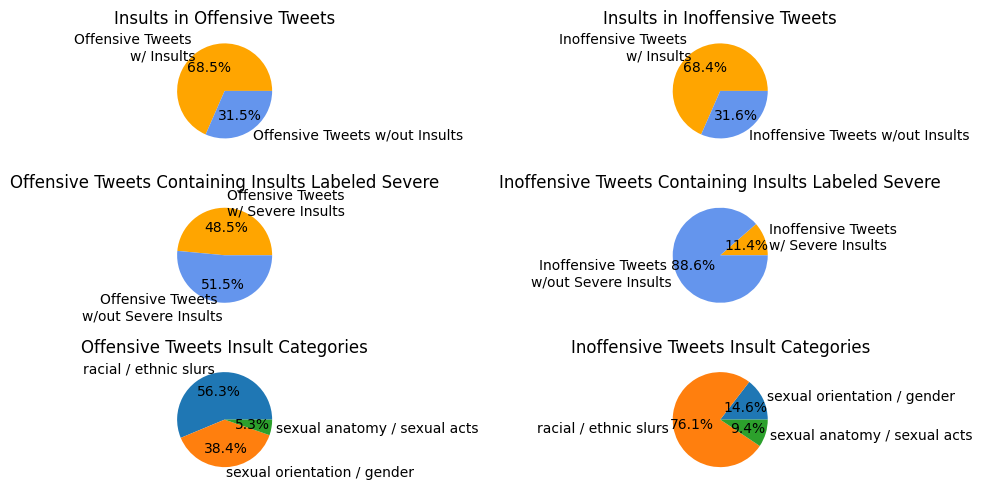

In [114]:
# Count the number of tweets with and without insults for offensive and inoffensive tweets
no_insults_offensive_count = offensive_tweets['contains_insult'].isna().sum()
no_insults_inoffensive_count = inoffensive_tweets['contains_insult'].isna().sum()

# Count the number of tweets without severe insults for offensive and inoffensive tweets
severe_offensive_count = (offensive_tweets['contains_severe_insult'] == True).sum()
no_severe_offensive_count = (offensive_tweets['contains_severe_insult'] == False).sum()

severe_inoffensive_count = (inoffensive_tweets['contains_severe_insult'] == True).sum()
no_severe_inoffensive_count = (inoffensive_tweets['contains_severe_insult'] == False).sum()

# Plotting pie charts
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Pie chart for offensive tweets
axs[0][0].pie([offensive_tweets['contains_insult'].size - no_insults_offensive_count, no_insults_offensive_count], 
       labels=['Offensive Tweets \nw/ Insults', 'Offensive Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][0].set_title('Insults in Offensive Tweets')

# Pie chart for inoffensive tweets
axs[0][1].pie([inoffensive_tweets['contains_insult'].size - no_insults_inoffensive_count, no_insults_inoffensive_count], 
       labels=['Inoffensive Tweets \nw/ Insults', 'Inoffensive Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][1].set_title('Insults in Inoffensive Tweets')

axs[1][0].pie([severe_offensive_count, no_severe_offensive_count],
              labels=['Offensive Tweets \nw/ Severe Insults','Offensive Tweets \nw/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][0].set_title('Offensive Tweets Containing Insults Labeled Severe')

axs[1][1].pie([severe_inoffensive_count, no_severe_inoffensive_count],
              labels=['Inoffensive Tweets \nw/ Severe Insults','Inoffensive Tweets \nw/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][1].set_title('Inoffensive Tweets Containing Insults Labeled Severe')

axs[2][0].pie([x for x in insult_offensive_categories.values()],
              labels=[x for x in insult_offensive_categories.keys()], autopct='%1.1f%%')
axs[2][0].set_title('Offensive Tweets Insult Categories')

axs[2][1].pie([x for x in insult_inoffensive_categories.values()],
              labels=[x for x in insult_inoffensive_categories.keys()], autopct='%1.1f%%')
axs[2][1].set_title('Inoffensive Tweets Insult Categories')

plt.tight_layout()
plt.show()

# Create pie chart

# Extract category labels and frequencies
# insult_offensive_categories
# insult_inoffensive_categories
categories_offensive_insults = list(insult_offensive_categories.keys())
frequencies_offensive_insults = list(insult_offensive_categories.values())

categories_inoffensive_insults = list(insult_inoffensive_categories.keys())
frequencies_inoffensive_insults = list(insult_inoffensive_categories.values())
